In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate
from scipy import integrate as integrate
import pandas as pd
from scipy.optimize import minimize
from scipy.special import erf
from matplotlib import cm
import scipy.integrate
from scipy import optimize
from scipy.integrate import odeint
from scipy import integrate as integrate
from scipy.interpolate import CubicSpline
from scipy.interpolate import lagrange

In [3]:
from getdist import plots, MCSamples
import getdist
import time
from scipy.integrate import odeint

In [4]:
plt.style.use('default')
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

In [5]:
import os
os.environ["OMP_NUM_THREADS"] = "1"

In [6]:
def E( parameters,z):  
    omega=parameters[0]
    alpha=parameters[1]
    
    sol = odeint (KG_eqn, y0(alpha), t, args=(parameters,))
    a=sol[:,0]
    phi=sol[:,1]
    phi_dot = sol[:,2]
    rho_m = sol[:,3]
    kappa_alpha = kappa(alpha)
    V = (1/2)*kappa_alpha/(phi)**(alpha)
    rho_phi = 0.5*phi_dot**2 + V
    omega_exp = rho_m/(rho_phi+rho_m)
    i = np.where(omega_exp>=omega)
    i=i[0]
    if (len(i)>1):
        i=i[-1]

    rho_critical = rho_m[i]+rho_phi[i]
    a_z = 1/(1+z)

    a = a/sol[i,0]
    j = np.where(a >= a_z)[0]
    j=j[0]
   
    omega_m_theo = rho_m[j]/(rho_critical)
    omega_phi_theo = rho_phi[j]/(rho_critical)
    return np.sqrt(omega_m_theo+omega_phi_theo)

In [7]:
def E_sol(rho_critical,rho_m,rho_phi,a,z):
    a_z = 1/(1+z)
    
    j = np.where(a >= a_z)[0]
    j=j[0]
    
    omega_m_theo = rho_m[j]/(rho_critical)
    omega_phi_theo = rho_phi[j]/(rho_critical)
    return np.sqrt(omega_m_theo+omega_phi_theo)    

In [8]:
def erf_new(x):
    return ((4/np.pi)**(1/2))*(erf(x)-erf(0))

In [9]:
def alphaf(parameters,sigma_Ho,sigma,z,E_array):
    #sigma,z,H_obs are vectors

    n = len(sigma)
    alpha0=1/(sigma_Ho)**2
    for i in range(n):
        alpha0 = alpha0 + (E_array[i]/sigma[i])**2
        
    return alpha0

In [10]:
def beta(parameters,Ho,sigma_Ho,H_obs,sigma,z,E_array):
    n = len(sigma)
    beta0=Ho/((sigma_Ho)**2)
    for i in range(n):
        beta0 = beta0 + (E_array[i]*H_obs[i]/((sigma[i])**2))
        
    return beta0
    

In [11]:
def gamma(Ho,sigma_Ho,H_obs,sigma,E_array):
    n = len(sigma)
    gamma0=(Ho/(sigma_Ho))**2
    for i in range(n):
        gamma0 = gamma0 + (H_obs[i]/sigma[i])**2
        
    return gamma0 

In [12]:
def Likelihood(parameters,Ho,sigma_Ho,H_obs,sigma,z):
    
    omega=parameters[0]
    alpha=parameters[1]
    t_initial = 10**(-5)
    t_final = 150
    dt = 10**(-3)
    t = np.arange(0., t_final, dt)
    start = time.time()
    sol = odeint (KG_eqn, y0(alpha), t, args=(parameters,))
    end= time.time()
    a=sol[:,0]
    phi=sol[:,1]
    phi_dot = sol[:,2]
    rho_m = sol[:,3]
    kappa_alpha = kappa(alpha)
    V = (1/2)*kappa_alpha/(phi)**(alpha)
    rho_phi = 0.5*phi_dot**2 + V
    omega_exp = rho_m/(rho_phi+rho_m)
    i = np.where(omega_exp>=omega)
    i=i[0]
    if (len(i)>1):
        i=i[-1]
    else:
        i=len(t)-1

    rho_critical = rho_m[i]+rho_phi[i]
    a = a/sol[i,0]
    E_array = np.zeros(len(z_obs))
    
    for i in range(len(z_obs)):
        
        E_array[i] = E_sol(rho_critical,rho_m,rho_phi,a,z_obs[i])
        
    
    
    alpha0= alphaf(parameters,sigma_Ho,sigma,z,E_array)
    beta0= beta(parameters,Ho,sigma_Ho,H_obs,sigma,z,E_array)
    gamma0= gamma(Ho,sigma_Ho,H_obs,sigma,E_array)
    LH1= (1/(4*alpha0*((sigma_Ho)**2)))**(1/2)
    LH2= np.exp(-gamma0/2+(((beta0)**2)/(2*alpha0)))
    LH3 = 1+ erf_new(beta0/((2*alpha0)**(1/2)))
    
    return (LH1*LH2*LH3)

In [13]:
def Chi_sq(parameters,Ho,sigma_Ho,H_obs,sigma,z):
    return (-2*np.log(Likelihood(parameters,Ho,sigma_Ho,H_obs,sigma,z)))

In [14]:
def log_likelihood(parameters,Ho,sigma_Ho,H_obs,sigma,z):
    return np.log(Likelihood(parameters,Ho,sigma_Ho,H_obs,sigma,z))

In [15]:
def log_prior(parameters):
    omega,alpha = parameters
    if 0.01 < omega < 0.70 and 0.00001 < alpha < 5:
        return 0.0
    return -np.inf

In [16]:
def log_probability(parameters,Ho,sigma_Ho,H_obs,sigma,z):
    lp = log_prior(parameters)
    if not np.isfinite(lp):
        return -np.inf
   
    return lp + log_likelihood(parameters,Ho,sigma_Ho,H_obs,sigma,z)

In [17]:
def kappa(alpha):
    p1= (8*alpha+32)/(3*alpha+6)
    p2= ((2*(alpha**2)+4*alpha)/3)**(alpha/2)
    return p1*p2

In [18]:
def y0(alpha):
    t0 = 10**(-5)
    a_initial = t0**(2/3)
    phi_initial =   ((2*alpha*(alpha+2)/3)**(1/2))*((t0)**(2/(alpha+2)))
   
    phi_dot_initial = (2/(alpha+2))*(phi_initial)/t0
    
    Ho = 70 
    rho_cr0 = 3*Ho**2/(8*np.pi)

    Omega_m = 0.28
    rho_m0 = Omega_m*rho_cr0
    rho_initial = rho_m0/(a_initial**3) # initial value for the matter density
    
    return a_initial,phi_initial,phi_dot_initial,rho_initial

In [19]:
t_initial = 10**(-5)
t_final = 150
dt = t_initial
t = np.arange(0., t_final, dt)

In [20]:
def KG_eqn(y, t, parameters):
    a,phi,phi_dot,rho_m = y
    alpha=parameters[1]
    kappa_alpha = kappa(alpha)
    mp = 1
    V = (1/2)*kappa_alpha*mp**2/(phi)**(alpha)
    rho_phi = 0.5*phi_dot**2 + V
    Hubble_rate = np.sqrt((8*np.pi/3)* (rho_phi + rho_m))
    dydt = [a*Hubble_rate,phi_dot,-3*Hubble_rate*phi_dot+ 0.5*kappa_alpha*alpha/(phi**(alpha+1)), -3*rho_m*Hubble_rate ]
    return dydt

In [21]:
parameters = [0.30,0.01]
Ho=70

In [22]:
#from scipy.integrate import odeint
start = time.time()
sol = odeint(KG_eqn, y0(0.01), t, args=(parameters,))
end= time.time()
print(end-start)

2.535147190093994


In [23]:
a = sol[:,0]
phi=sol[:,1]
phi_dot=sol[:,2]
rho_m = sol[:,3]
H=[]
alpha = 0.01
print(phi,phi_dot,rho_m)
kappa_alpha = kappa(alpha)
V = (1/2)*kappa_alpha/(phi)**(alpha)
rho_phi = 0.5*phi_dot**2 + V
Hubble_rate = np.sqrt((8*np.pi/3)* (rho_phi + rho_m))




[1.22582372e-06 1.62562034e-06 2.49481185e-06 ... 7.48530391e-01
 7.48530416e-01 7.48530441e-01] [0.12197251 0.06864485 0.1003882  ... 0.00248659 0.00248659 0.00248658] [ 1.63770436e+12  5.11923129e+08  1.30273855e+08 ... -2.64520033e-10
 -2.64774739e-10 -2.65029321e-10]


In [24]:
Data = pd.read_csv("Data.csv")
print(Data)
Data = Data.to_numpy()
z_obs = Data[:,0]
H_obs = Data[:,1]
sigma_obs = Data[:,2]
print(z_obs)

        z  H(z)(kms−1Mpc−1)  std_deviation(kms−1Mpc−1)
0   0.070              69.0                       19.6
1   0.090              69.0                       12.0
2   0.120              68.6                       26.2
3   0.170              83.0                        8.0
4   0.179              75.0                        4.0
5   0.199              75.0                        5.0
6   0.200              72.9                       29.6
7   0.270              77.0                       14.0
8   0.280              88.8                       36.6
9   0.350              76.3                        5.6
10  0.352              83.0                       14.0
11  0.400              95.0                       17.0
12  0.440              82.6                        7.8
13  0.480              97.0                       62.0
14  0.593             104.0                       13.0
15  0.600              87.9                        6.1
16  0.680              92.0                        8.0
17  0.730 

In [25]:
Ho= 68
sigma_Ho=2.8

In [26]:
best_fit_params2 = minimize (Chi_sq,x0=[0.30,0.01],args=(68,2.8,H_obs,sigma_obs,z_obs),method='L-BFGS-B',bounds=[(0,2),(0,5)])
print(best_fit_params2)

  message: ABNORMAL_TERMINATION_IN_LNSRCH
  success: False
   status: 2
      fun: 17.94546253809511
        x: [ 3.000e-01  1.035e-02]
      nit: 1
      jac: [ 0.000e+00 -4.248e-01]
     nfev: 156
     njev: 52
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>


In [27]:
best_fit_params2 = minimize (Chi_sq,x0=[0.30,0],args=(73.8,2.4,H_obs,sigma_obs,z_obs),method='L-BFGS-B',bounds=[(0,1),(-0.25,0.25)])
print(best_fit_params2)
print(np.round((best_fit_params2.fun),2))
print(np.round((best_fit_params2.x),2))


C:\Users\sriva\AppData\Local\Temp\ipykernel_14272\2644748085.py:9: RuntimeWarning: invalid value encountered in scalar divide
  dydt = [a*Hubble_rate,phi_dot,-3*Hubble_rate*phi_dot+ 0.5*kappa_alpha*alpha/(phi**(alpha+1)), -3*rho_m*Hubble_rate ]
C:\Users\sriva\AppData\Local\Temp\ipykernel_14272\4088500705.py:10: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  sol = odeint (KG_eqn, y0(alpha), t, args=(parameters,))
C:\Users\sriva\AppData\Local\Temp\ipykernel_14272\4088500705.py:28: RuntimeWarning: divide by zero encountered in divide
  a = a/sol[i,0]
C:\Users\sriva\AppData\Local\Temp\ipykernel_14272\4088500705.py:28: RuntimeWarning: invalid value encountered in divide
  a = a/sol[i,0]
C:\Users\sriva\AppData\Local\Temp\ipykernel_14272\2644748085.py:9: RuntimeWarning: overflow encountered in scalar multiply
  dydt = [a*Hubble_rate,phi_dot,-3*Hubble_rate*phi_dot+ 0.5*kappa_alpha*alpha/(phi**(alpha+1)), -3*rho_m*Hub

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 22.90376479521249
        x: [ 3.000e-01  4.181e-06]
      nit: 2
      jac: [ 0.000e+00 -2.710e+01]
     nfev: 63
     njev: 21
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
22.9
[0.3 0. ]


In [28]:
import emcee
from multiprocessing import Pool
pos = best_fit_params2.x + 1e-4 * np.random.randn(100, 2)
nwalkers, ndim = pos.shape
print("done0")
filename = "Ho68_phiCDM.h5"
backend = emcee.backends.HDFBackend(filename)
backend.reset(nwalkers, ndim)
print("done1")

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(68,2.8,H_obs,sigma_obs,z_obs),backend=backend
)
start = time.time()
sampler.run_mcmc(pos, 10000, progress=True);
end = time.time()
print(end-start)

done0
done1


C:\Users\sriva\AppData\Local\Temp\ipykernel_14272\2644748085.py:9: RuntimeWarning: overflow encountered in scalar multiply
  dydt = [a*Hubble_rate,phi_dot,-3*Hubble_rate*phi_dot+ 0.5*kappa_alpha*alpha/(phi**(alpha+1)), -3*rho_m*Hubble_rate ]
C:\Users\sriva\AppData\Local\Temp\ipykernel_14272\4088500705.py:10: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  sol = odeint (KG_eqn, y0(alpha), t, args=(parameters,))
C:\Users\sriva\AppData\Local\Temp\ipykernel_14272\4088500705.py:17: RuntimeWarning: divide by zero encountered in divide
  V = (1/2)*kappa_alpha/(phi)**(alpha)
  0%|          | 0/10000 [00:00<?, ?it/s]C:\Users\sriva\AppData\Roaming\Python\Python312\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 10000/10000 [20:34:24<00:00,  7.41s/it]  

74073.17383003235


In [29]:
max_n = 10000

# We'll track how the average autocorrelation time estimate changes
index = 0
autocorr = np.empty(max_n)

# This will be useful to testing convergence
old_tau = np.inf

# Now we'll sample for up to max_n steps
for sample in sampler.sample(pos, iterations=max_n, progress=True):
    # Only check convergence every 100 steps
    if sampler.iteration % 100:
        continue

    # Compute the autocorrelation time so far
    # Using tol=0 means that we'll always get an estimate even
    # if it isn't trustworthy
    tau = sampler.get_autocorr_time(tol=0)
    autocorr[index] = np.mean(tau)
    index += 1

    # Check convergence
    converged = np.all(tau * 100 < sampler.iteration)
    converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
    if converged:
        break
    old_tau = tau

C:\Users\sriva\AppData\Local\Temp\ipykernel_14272\2644748085.py:9: RuntimeWarning: overflow encountered in scalar multiply
  dydt = [a*Hubble_rate,phi_dot,-3*Hubble_rate*phi_dot+ 0.5*kappa_alpha*alpha/(phi**(alpha+1)), -3*rho_m*Hubble_rate ]
C:\Users\sriva\AppData\Local\Temp\ipykernel_14272\4088500705.py:10: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  sol = odeint (KG_eqn, y0(alpha), t, args=(parameters,))
C:\Users\sriva\AppData\Local\Temp\ipykernel_14272\4088500705.py:17: RuntimeWarning: divide by zero encountered in divide
  V = (1/2)*kappa_alpha/(phi)**(alpha)
  3%|▎         | 313/10000 [1:28:50<19:25:02,  7.22s/it]   Traceback (most recent call last):
  File "C:\Users\sriva\AppData\Roaming\Python\Python312\site-packages\emcee\ensemble.py", line 640, in __call__
    return self.f(x, *self.args, **self.kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\sriva\AppData\Local\Temp\ipykernel_1427

emcee: Exception while calling your likelihood function:
  params: [0.1704372  1.32766622]
  args: (68, 2.8, array([ 69. ,  69. ,  68.6,  83. ,  75. ,  75. ,  72.9,  77. ,  88.8,
        76.3,  83. ,  95. ,  82.6,  97. , 104. ,  87.9,  92. ,  97.3,
       105. , 125. ,  90. , 117. , 154. , 168. , 177. , 140. , 202. ,
       224. ]), array([19.6, 12. , 26.2,  8. ,  4. ,  5. , 29.6, 14. , 36.6,  5.6, 14. ,
       17. ,  7.8, 62. , 13. ,  6.1,  8. ,  7. , 12. , 17. , 40. , 23. ,
       20. , 17. , 18. , 14. , 40. ,  8. ]), array([0.07 , 0.09 , 0.12 , 0.17 , 0.179, 0.199, 0.2  , 0.27 , 0.28 ,
       0.35 , 0.352, 0.4  , 0.44 , 0.48 , 0.593, 0.6  , 0.68 , 0.73 ,
       0.781, 0.875, 0.88 , 0.9  , 1.037, 1.3  , 1.43 , 1.53 , 1.75 ,
       2.3  ]))
  kwargs: {}
  exception:


KeyboardInterrupt: 

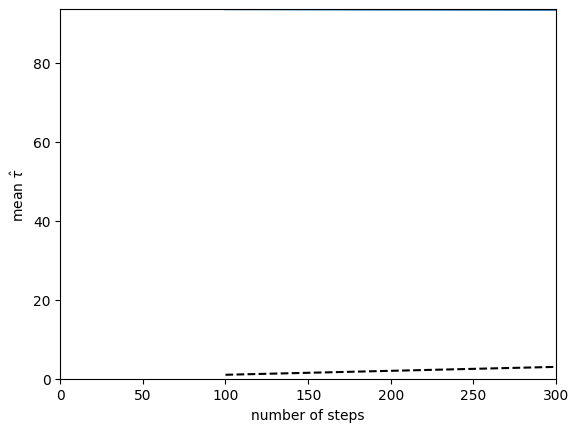

In [31]:
import matplotlib.pyplot as plt

n = 100 * np.arange(1, index + 1)
y = autocorr[:index]
plt.plot(n, n / 100.0, "--k")
plt.plot(n, y)
plt.xlim(0, n.max())
plt.ylim(0, y.max() + 0.1 * (y.max() - y.min()))
plt.xlabel("number of steps")
plt.ylabel(r"mean $\hat{\tau}$");

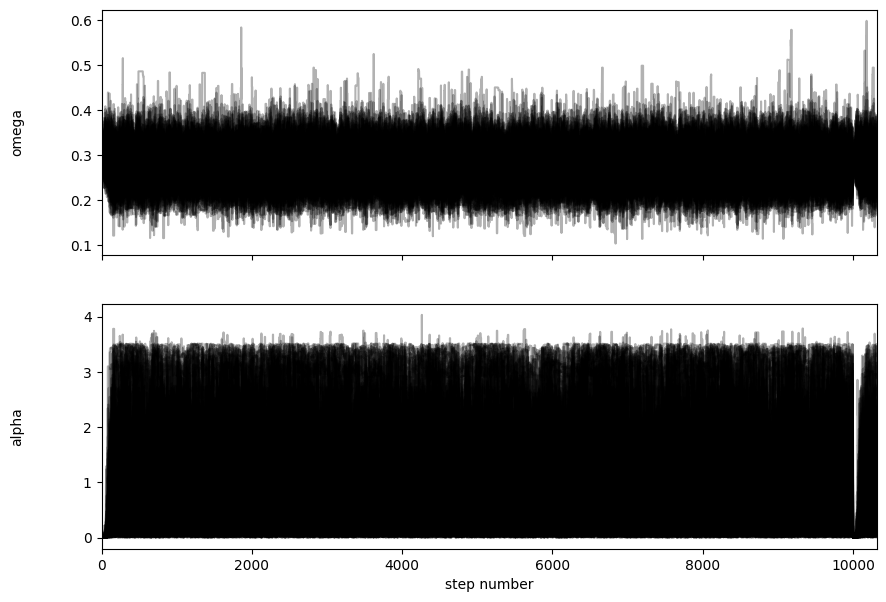

In [32]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["omega", "alpha"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1,0.5)

axes[-1].set_xlabel("step number");

In [33]:
tau = sampler.get_autocorr_time()
tau = sampler.get_autocorr_time()
burnin = int(2 * np.max(tau))
thin = int(0.5 * np.min(tau))
flat_samples = sampler.get_chain(discard=burnin, thin=thin, flat=True)
print("burn-in: {0}".format(burnin))
print("thin: {0}".format(thin))
print("flat chain shape: {0}".format(flat_samples.shape))

burn-in: 233
thin: 34
flat chain shape: (29600, 2)


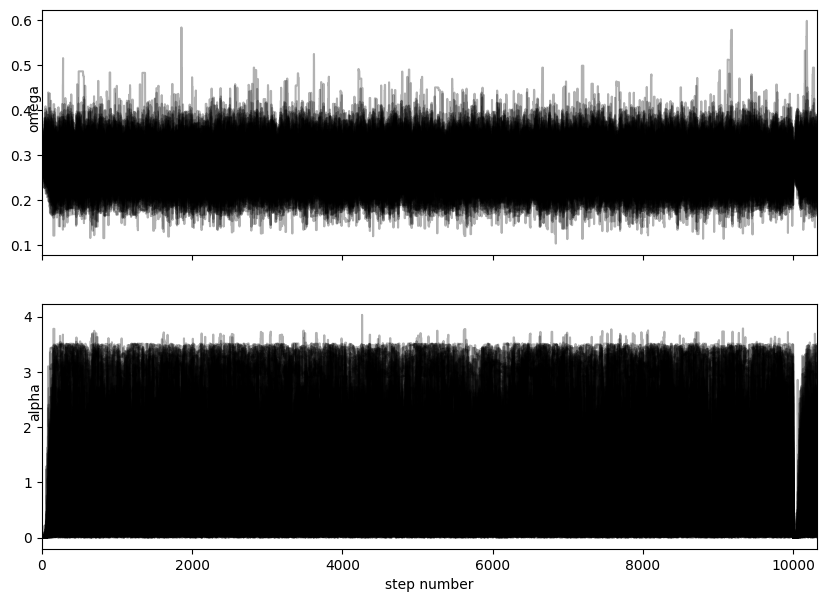

In [34]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["omega", "alpha"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(0,0.60)

axes[-1].set_xlabel("step number");

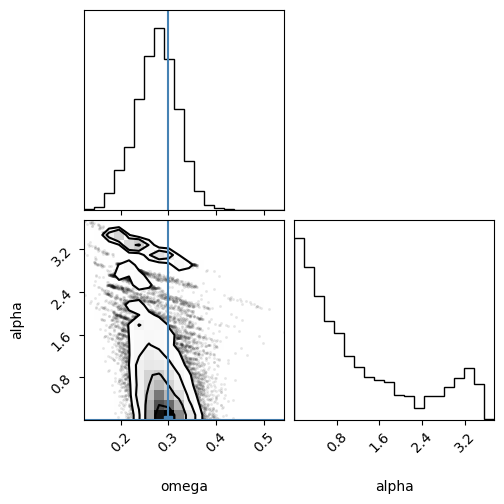

In [35]:
import corner
labels = ["omega","alpha"]
fig = corner.corner(
    flat_samples, labels=labels, truths= best_fit_params2.x
);

In [36]:
ndim = 2
nsamp = 132400
samps = flat_samples
#samps2 = flat_samples2

In [37]:
names = ["omega","alpha"]
labels =  ["\Omega_{mo}","alpha"]
samples = MCSamples(samples=samps,names = names, labels = labels)
#samples2 = MCSamples(samples=samps2,names = names, labels = labels)

Removed no burn in


<>:2: SyntaxWarning: invalid escape sequence '\O'
<>:2: SyntaxWarning: invalid escape sequence '\O'
C:\Users\sriva\AppData\Local\Temp\ipykernel_14272\1800365619.py:2: SyntaxWarning: invalid escape sequence '\O'
  labels =  ["\Omega_{mo}","alpha"]


(0.0, 0.5)

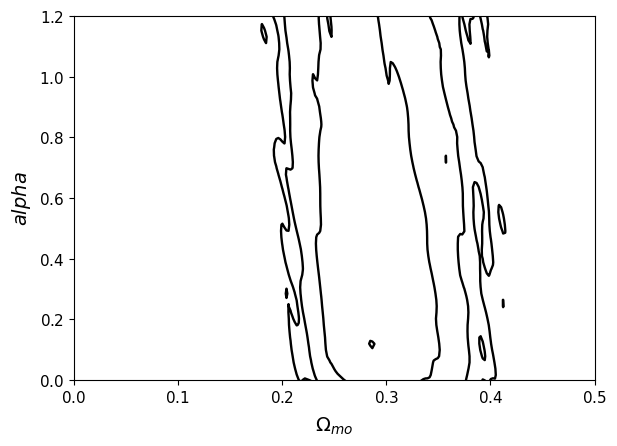

In [38]:
g = plots.get_single_plotter()
ax1= g.get_axes()
samples.updateSettings({'contours': [0.001,0.68, 0.95, 0.99]})
g.settings.num_plot_contours = 4
g.plot_2d(samples, 'omega', 'alpha');
ax1.set_ylim(0,1.2)
ax1.set_xlim(0,0.5)

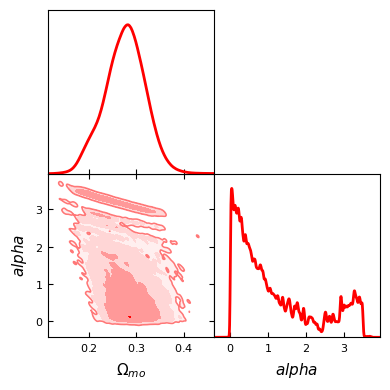

In [39]:
from matplotlib import cm
samples.updateSettings({'contours': [0.001,0.68, 0.95, 0.99]})
g = plots.get_subplot_plotter(subplot_size=2)
g.settings.num_plot_contours = 4
g.triangle_plot([samples], filled=True,contour_lws=2,contour_colors=['red']);


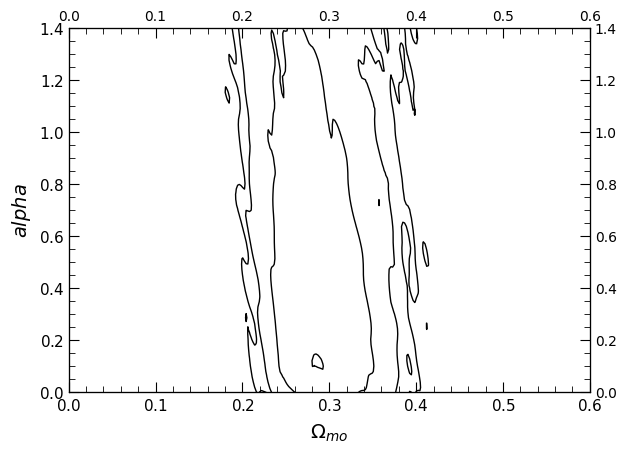

In [52]:
g = plots.get_single_plotter()
samples.updateSettings({'contours': [0.007,0.68, 0.95, 0.99]})
#samples2.updateSettings({'contours': [0.001,0.68, 0.95, 0.99]})
g.settings.num_plot_contours = 4
g.plot_2d([samples], 'omega', 'alpha',lws=[1],filled=[False],colors=["Black"],ls=["solid"]);
#g.plot_2d([samples2], 'omega', 'omega_lambda',lws=[1],filled=[False],colors=["Black"],ls=["solid"]);
#g.add_legend(['$H_o=68 \pm 2.8$'], bbox_to_anchor=(0.5,0.9));
ax1= g.get_axes()

ax1.set_ylim(0,1.4)
ax1.set_xlim(0,0.6)
ax1.xaxis.set_major_locator(MultipleLocator(0.1))
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_major_locator(MultipleLocator(0.2))
ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which ='both',direction='in')
ax1.tick_params(which='major', length=7)
ax1.tick_params(which='minor', length=4)

ax2 = ax1.twinx()
ax2.tick_params(direction='in')
ax2.set_ylim(0,1.4)
ax3= ax1.twiny()
ax3.tick_params(direction='in')
ax3.set_xlim(0,0.6)
ax3.xaxis.set_major_locator(MultipleLocator(0.1))
ax3.xaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_major_locator(MultipleLocator(0.2))
ax2.yaxis.set_minor_locator(AutoMinorLocator())
ax2.tick_params(which ='both',direction='in')
ax2.tick_params(which='major', length=7)
ax2.tick_params(which='minor', length=4)
ax3.tick_params(which ='both',direction='in')
ax3.tick_params(which='major', length=7)
ax3.tick_params(which='minor', length=4)
plt.show()



In [43]:
from IPython.display import display, Math

for i in range(2):
    mcmc = np.percentile(flat_samples[:, i], [5, 50, 95])
    q = np.diff(mcmc)
    minimum = mcmc[1]-q[0]
    maximum = mcmc[1]+q[1]
    txt = "\mathrm{{{3}}} = {0:.2f}_{{{1:.2f}}}^{{{2:.2f}}}"
    txt = txt.format(mcmc[1], mcmc[1]-q[0], mcmc[1]+q[1], labels[i])
    display(Math(txt))

<>:8: SyntaxWarning: invalid escape sequence '\m'
<>:8: SyntaxWarning: invalid escape sequence '\m'
C:\Users\sriva\AppData\Local\Temp\ipykernel_14272\1522526908.py:8: SyntaxWarning: invalid escape sequence '\m'
  txt = "\mathrm{{{3}}} = {0:.2f}_{{{1:.2f}}}^{{{2:.2f}}}"


<IPython.core.display.Math object>

<IPython.core.display.Math object>